Đã thiết lập Random Seed: 42
>>> ĐANG TẢI DỮ LIỆU ETH...
Dữ liệu từ 2022-01-01 đến 2025-12-08 | Tổng: 1438 dòng
Features (With On-chain): 13
Features (No On-chain): 8

  CHẠY HYBRID MODEL: WITH_ONCHAIN
BiLSTM Gốc MAE: 216.34
Hybrid Adj MAE: 210.16

  CHẠY HYBRID MODEL: NO_ONCHAIN
BiLSTM Gốc MAE: 133.74
Hybrid Adj MAE: 127.87

  CHẠY GRU MODEL (BASELINE): GRU_ONCHAIN
GRU Model MAE: 85.96

  CHẠY GRU MODEL (BASELINE): GRU_NO_ONCHAIN
GRU Model MAE: 50.56


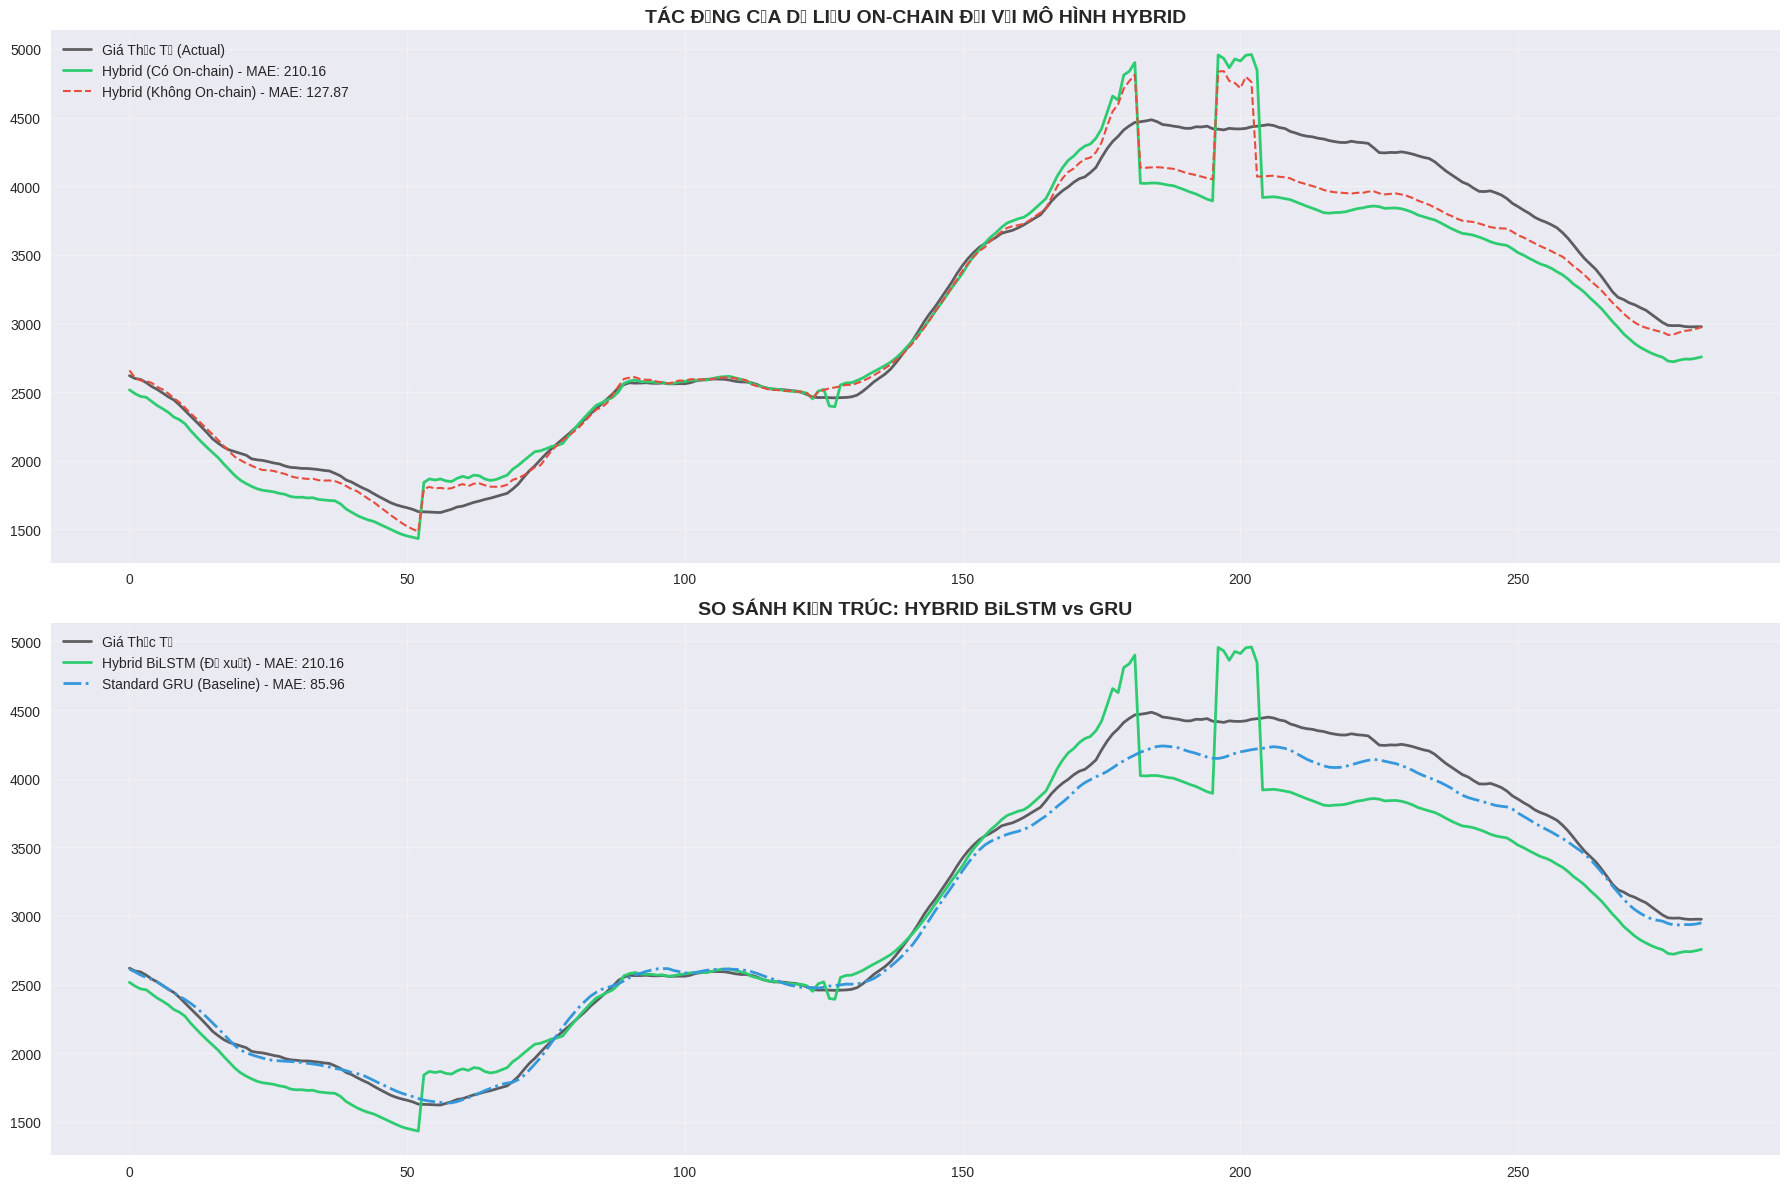


             BẢNG TỔNG HỢP KẾT QUẢ CUỐI CÙNG
Mô hình                        | MAE        | RMSE      
------------------------------------------------------------
Hybrid + On-chain (Best)       | 210.16     | 268.10     | 0.07      
Hybrid No On-chain             | 127.87     | 180.30     | 0.04      
GRU Model (Baseline)           | 85.96      | 117.19     | 0.02      
GRU Model No On-chain          | 50.56      | 66.86298283340751 | 0.02      


In [ ]:
# =============================================================================
# ĐỒ ÁN DỰ ĐOÁN GIÁ ETH - SO SÁNH TOÀN DIỆN
# 1. Hybrid BiLSTM (On-chain)
# 2. Hybrid BiLSTM (No On-chain)
# 3. GRU Model (Baseline Comparison)
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import warnings
import random

SEED = 42  # Bạn có thể chọn số bất kỳ (ví dụ 42, 123, 2024)

# 1. Cố định seed cho Python
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)

# 2. Cố định seed cho Numpy
np.random.seed(SEED)

# 3. Cố định seed cho TensorFlow
tf.random.set_seed(SEED)

# 4. Cấu hình để dùng thuật toán xác định (nếu dùng GPU)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

print(f"Đã thiết lập Random Seed: {SEED}")

# Tắt cảnh báo để output sạch hơn
warnings.filterwarnings('ignore')

# Cấu hình giao diện biểu đồ
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ===============================
# 1. LOAD DỮ LIỆU & TIỀN XỬ LÝ
# ===============================
print(">>> ĐANG TẢI DỮ LIỆU ETH...")
# Đảm bảo file 'merged_dataset.csv' nằm cùng thư mục
try:
    df = pd.read_csv('merged_dataset.csv')
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df.sort_index(inplace=True)
    print(f"Dữ liệu từ {df.index[0].date()} đến {df.index[-1].date()} | Tổng: {len(df)} dòng")
except FileNotFoundError:
    print("LỖI: Không tìm thấy file 'merged_dataset.csv'. Vui lòng kiểm tra lại đường dẫn.")
    exit()

# ===============================
# 2. TÍNH TOÁN CHỈ BÁO KỸ THUẬT
# ===============================
def calculate_technical_indicators(df):
    df = df.copy()
    # Trend Indicators
    df['SMA_20'] = df['close'].rolling(20).mean()
    df['SMA_50'] = df['close'].rolling(50).mean()
    df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Momentum Indicators
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # Volatility Indicators
    df['BB_middle'] = df['close'].rolling(20).mean()
    bb_std = df['close'].rolling(20).std()
    df['BB_upper'] = df['BB_middle'] + 2 * bb_std
    df['BB_lower'] = df['BB_middle'] - 2 * bb_std
    df['BB_position'] = (df['close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

    # Oscillator
    low_14 = df['low'].rolling(14).min()
    high_14 = df['high'].rolling(14).max()
    df['STOCH_%K'] = 100 * (df['close'] - low_14) / (high_14 - low_14)
    df['Williams_%R'] = -100 * (high_14 - df['close']) / (high_14 - low_14)

    # ATR
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR_14'] = tr.rolling(14).mean()

    # Volume & ROC
    df['Volume_SMA_20'] = df['volume'].rolling(20).mean()
    df['Volume_ratio'] = df['volume'] / df['Volume_SMA_20']
    df['ROC_10'] = df['close'].pct_change(periods=10) * 100

    return df

df = calculate_technical_indicators(df)

# ===============================
# 3. ĐỊNH NGHĨA FEATURES SETS
# ===============================
onchain_cols = ['net_issuance', 'median_gas_price_gwei', "new_addresses", 'eth_transferred', 'validator_rewards_eth']
base_features = ['SMA_20','MACD_signal', 'BB_position', 'Williams_%R', 'ATR_14', 'Volume_ratio', 'ROC_10', 'volume']

# Set 1: Có On-chain
features_with_onchain = base_features + onchain_cols
# Set 2: Không On-chain
features_without_onchain = base_features.copy()

print(f"Features (With On-chain): {len(features_with_onchain)}")
print(f"Features (No On-chain): {len(features_without_onchain)}")

# ===============================
# 4. HÀM CHẠY HYBRID MODEL (BiLSTM + CLASSIFICATION)
# ===============================
def run_hybrid_model(feature_list, version_name, time_steps=60):
    print(f"\n{'='*60}")
    print(f"  CHẠY HYBRID MODEL: {version_name}")
    print(f"{'='*60}")

    # Chuẩn bị dữ liệu
    data = df[feature_list].copy()
    data['close_smooth'] = data['SMA_20'] # Target chính (làm mượt)
    # Target phụ (Classification): 1 nếu giá mai tăng, 0 nếu giảm
    data['trend_next_day'] = (data['close_smooth'].shift(-1) > data['close_smooth']).astype(int)
    data_clean = data.dropna().copy()

    train_size = int(len(data_clean) * 0.8)
    train_data = data_clean.iloc[:train_size]
    test_data = data_clean.iloc[train_size:]

    # --- A. TREND CLASSIFICATION (DENSE/MLP) ---
    X_trend_train = train_data[feature_list].values
    y_trend_train = train_data['trend_next_day'].values
    X_trend_test = test_data[feature_list].values

    scaler_trend = MinMaxScaler()
    X_train_tr = scaler_trend.fit_transform(X_trend_train)
    X_test_tr = scaler_trend.transform(X_trend_test)

    # Xây dựng hoặc load model Trend
    model_path_trend = f"trend_model_{version_name}.keras"
    if os.path.exists(model_path_trend):
        model_trend = load_model(model_path_trend)
    else:
        model_trend = Sequential([
            Dense(128, activation='relu', input_shape=(X_train_tr.shape[1],)),
            Dropout(0.4), Dense(64, activation='relu'), Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        model_trend.compile(optimizer=Adam(0.0005), loss='binary_crossentropy', metrics=['accuracy'])
        model_trend.fit(X_train_tr, y_trend_train, epochs=50, batch_size=32, verbose=0,
                        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
        model_trend.save(model_path_trend)

    y_pred_trend_proba = model_trend.predict(X_test_tr, verbose=0).flatten()

    # --- B. PRICE REGRESSION (BiLSTM) ---
    reg_features = [col for col in feature_list if col != 'close']
    target = 'close_smooth'

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_X.fit(train_data[reg_features])
    scaler_y.fit(train_data[[target]])

    full_X = scaler_X.transform(data_clean[reg_features])
    full_y = scaler_y.transform(data_clean[[target]])

    def create_seq(X, y, ts):
        Xs, ys = [], []
        for i in range(ts, len(X)):
            Xs.append(X[i-ts:i])
            ys.append(y[i, 0])
        return np.array(Xs), np.array(ys)

    X_full, y_full = create_seq(full_X, full_y, time_steps)
    split_idx = train_size - time_steps
    X_train, y_train = X_full[:split_idx], y_full[:split_idx]
    X_test, y_test = X_full[split_idx:], y_full[split_idx:]

    model_path_reg = f"bilstm_{version_name}.keras"
    if os.path.exists(model_path_reg):
        model_reg = load_model(model_path_reg)
    else:
        model_reg = Sequential([
            Bidirectional(LSTM(50, return_sequences=True), input_shape=(time_steps, len(reg_features))),
            Dropout(0.2),
            Bidirectional(LSTM(50)),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1)
        ])
        model_reg.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
        model_reg.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0,
                      callbacks=[EarlyStopping(patience=15, restore_best_weights=True),
                                 ReduceLROnPlateau(patience=5, factor=0.5)])
        model_reg.save(model_path_reg)

    y_pred_scaled = model_reg.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_true = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()

    # --- C. HYBRID CORRECTION ---
    # Lấy giá đóng cửa ngày hôm trước để làm mốc so sánh
    test_indices = data_clean.index[train_size:]
    prev_close = data_clean.loc[test_indices, 'close_smooth'].shift(1).values

    # Cắt ngắn các mảng cho bằng nhau (do windowing)
    min_len = min(len(y_true), len(y_pred), len(prev_close), len(y_pred_trend_proba))
    y_true = y_true[-min_len:]
    y_pred = y_pred[-min_len:]
    prev_close = prev_close[-min_len:]
    trend_proba = y_pred_trend_proba[-min_len:]

    y_pred_adj = y_pred.copy()

    # Logic hiệu chỉnh: Nếu Trend Model cực chắc chắn, nhưng Regression dự đoán ngược -> Kéo lại
    for i in range(len(y_pred_adj)):
        if np.isnan(prev_close[i]): continue

        trend_up = trend_proba[i] > 0.5
        pred_up = y_pred[i] > prev_close[i]

        # Nếu mô hình Trend và Regress mâu thuẫn
        if pred_up != trend_up:
            diff = abs(y_pred[i] - prev_close[i])
            # Boost factor dựa trên độ tự tin của Trend model
            confidence = trend_proba[i] if trend_up else (1 - trend_proba[i])
            boost = 0.3 + confidence

            if trend_up: # Trend bảo tăng, Regress bảo giảm -> Kéo tăng
                y_pred_adj[i] = prev_close[i] + diff * boost
            else: # Trend bảo giảm, Regress bảo tăng -> Kéo giảm
                y_pred_adj[i] = prev_close[i] - diff * boost

    # Tính MAE
    mae_base = mean_absolute_error(y_true, y_pred)
    mae_adj = mean_absolute_error(y_true, y_pred_adj)
    print(f"BiLSTM Gốc MAE: {mae_base:.2f}")
    print(f"Hybrid Adj MAE: {mae_adj:.2f}")

    return y_true, y_pred, y_pred_adj

# ===============================
# 5. HÀM CHẠY GRU MODEL (MỚI BỔ SUNG)
# ===============================
def run_gru_model(feature_list, version_name, time_steps=60):
    print(f"\n{'='*60}")
    print(f"  CHẠY GRU MODEL (BASELINE): {version_name}")
    print(f"{'='*60}")

    data = df[feature_list].copy()
    data['close_smooth'] = data['SMA_20']
    data_clean = data.dropna().copy()

    train_size = int(len(data_clean) * 0.8)
    train_data = data_clean.iloc[:train_size]

    reg_features = [col for col in feature_list if col != 'close']
    target = 'close_smooth'

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    scaler_X.fit(train_data[reg_features])
    scaler_y.fit(train_data[[target]])

    full_X = scaler_X.transform(data_clean[reg_features])
    full_y = scaler_y.transform(data_clean[[target]])

    X_full, y_full = [], []
    for i in range(time_steps, len(full_X)):
        X_full.append(full_X[i-time_steps:i])
        y_full.append(full_y[i, 0])
    X_full, y_full = np.array(X_full), np.array(y_full)

    split_idx = train_size - time_steps
    X_train, y_train = X_full[:split_idx], y_full[:split_idx]
    X_test, y_test = X_full[split_idx:], y_full[split_idx:]

    model_path_gru = f"gru_{version_name}.keras"
    if os.path.exists(model_path_gru):
        model_gru = load_model(model_path_gru)
    else:
        # Kiến trúc GRU
        model_gru = Sequential([
            GRU(50, return_sequences=True, input_shape=(time_steps, len(reg_features))),
            Dropout(0.2),
            GRU(50),
            Dropout(0.2),
            Dense(25, activation='relu'),
            Dense(1)
        ])
        model_gru.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
        model_gru.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0,
                      validation_data=(X_test, y_test),
                      callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])
        model_gru.save(model_path_gru)

    y_pred_scaled = model_gru.predict(X_test, verbose=0)
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
    y_true = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()

    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[-min_len:]
    y_pred = y_pred[-min_len:]

    print(f"GRU Model MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    return y_true, y_pred

# ===============================
# 6. THỰC THI TOÀN BỘ VÀ SO SÁNH
# ===============================

# --- A. Chạy Hybrid CÓ On-chain ---
y_true_a, pred_base_a, pred_adj_a = run_hybrid_model(features_with_onchain, "WITH_ONCHAIN")

# --- B. Chạy Hybrid KHÔNG On-chain ---
y_true_b, pred_base_b, pred_adj_b = run_hybrid_model(features_without_onchain, "NO_ONCHAIN")

# --- C. Chạy GRU (Có On-chain để so sánh công bằng về kiến trúc) ---
y_true_gru, pred_gru = run_gru_model(features_with_onchain, "GRU_ONCHAIN")

# --- D. Chạy GRU (KHÔNG On-chain - Để so sánh toàn diện 2x2) ---
y_true_gru_no, pred_gru_no = run_gru_model(features_without_onchain, "GRU_NO_ONCHAIN")


# ===============================
# 7. VẼ BIỂU ĐỒ & BÁO CÁO
# ===============================
# Đồng bộ độ dài để vẽ (lấy phần cuối cùng chung nhất)
min_len_plot = min(len(y_true_a), len(pred_adj_a), len(pred_adj_b), len(pred_gru))

plot_true = y_true_a[-min_len_plot:]
plot_hybrid_onchain = pred_adj_a[-min_len_plot:]
plot_hybrid_nochain = pred_adj_b[-min_len_plot:]
plot_gru = pred_gru[-min_len_plot:]
plot_gru_no = pred_gru_no[-min_len_plot:]


# Tính chỉ số đánh giá cuối cùng
mae_hybrid_on = mean_absolute_error(plot_true, plot_hybrid_onchain)
mae_hybrid_no = mean_absolute_error(plot_true, plot_hybrid_nochain)
mape_hybrid_on = mean_absolute_percentage_error(plot_true, plot_hybrid_onchain)
mape_hybrid_no = mean_absolute_percentage_error(plot_true, plot_hybrid_nochain)

mae_gru = mean_absolute_error(plot_true, plot_gru)
mae_gru_no = mean_absolute_error(plot_true, plot_gru_no)
mape_gru = mean_absolute_percentage_error(plot_true, plot_gru)
mape_gru_no = mean_absolute_percentage_error(plot_true, plot_gru_no)

# --- VẼ ĐỒ THỊ ---
plt.figure(figsize=(18, 12))

# Subplot 1: Hybrid On-chain vs No On-chain
plt.subplot(2, 1, 1)
plt.plot(plot_true, label='Giá Thực Tế (Actual)', color='black', alpha=0.6, linewidth=2)
plt.plot(plot_hybrid_onchain, label=f'Hybrid (Có On-chain) - MAE: {mae_hybrid_on:.2f}', color='#2ecc71', linewidth=2)
plt.plot(plot_hybrid_nochain, label=f'Hybrid (Không On-chain) - MAE: {mae_hybrid_no:.2f}', color='#e74c3c', linestyle='--', linewidth=1.5)
plt.title('TÁC ĐỘNG CỦA DỮ LIỆU ON-CHAIN ĐỐI VỚI MÔ HÌNH HYBRID', fontsize=14, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Subplot 2: Hybrid BiLSTM vs GRU (Cùng dữ liệu On-chain)
plt.subplot(2, 1, 2)
plt.plot(plot_true, label='Giá Thực Tế', color='black', alpha=0.6, linewidth=2)
plt.plot(plot_hybrid_onchain, label=f'Hybrid BiLSTM (Đề xuất) - MAE: {mae_hybrid_on:.2f}', color='#2ecc71', linewidth=2)
plt.plot(plot_gru, label=f'Standard GRU (Baseline) - MAE: {mae_gru:.2f}', color='#3498db', linestyle='-.', linewidth=2)
# plt.plot(plot_gru_no, label=f'GRU (Không On-chain) - MAE: {mae_gru_no:.2f}',
#          color='orange', linestyle=':', linewidth=1.5)
plt.title('SO SÁNH KIẾN TRÚC: HYBRID BiLSTM vs GRU', fontsize=14, fontweight='bold')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- IN BẢNG TỔNG HỢP ---
print("\n" + "="*60)
print("             BẢNG TỔNG HỢP KẾT QUẢ CUỐI CÙNG")
print("="*60)
print(f"{'Mô hình':<30} | {'MAE':<10} | {'RMSE':<10}")
print("-" * 60)
print(f"{'Hybrid + On-chain (Best)':<30} | {mae_hybrid_on:<10.2f} | {np.sqrt(mean_squared_error(plot_true, plot_hybrid_onchain)):<10.2f} | {mape_hybrid_on: <10.2f}")
print(f"{'Hybrid No On-chain':<30} | {mae_hybrid_no:<10.2f} | {np.sqrt(mean_squared_error(plot_true, plot_hybrid_nochain)):<10.2f} | {mape_hybrid_no: <10.2f}")
print(f"{'GRU Model (Baseline)':<30} | {mae_gru:<10.2f} | {np.sqrt(mean_squared_error(plot_true, plot_gru)):<10.2f} | {mape_gru: <10.2f}")
print(f"{'GRU Model No On-chain':<30} | {mae_gru_no:<10.2f} | {np.sqrt(mean_squared_error(plot_true, plot_gru_no))} | {mape_gru_no: <10.2f}")
print("="*60)